# NYC PARKING TICKET DATASET ANALYSIS
---
Prepared By: Daypuyart, Lucky Mae B.; Mi, Li; Santos, Alliyah Jonachel P.

## EXECUTIVE SUMMARY

This notebook provides the clustering analysis of violation ticket dataset of New York. Furthermore, chunking was also utilized to read and load the big dataset amounting to about 4GB. The dataset used consists of two (2) fiscal year records of parking violation tickets released from New York Open Data – years 2018 and 2019. Moreover, the two dataset was originally comprised of about 23 million instances and 44 attributes which includes information that are considered by the office involved. <br><br>
In relation, the k-value used for clustering is 2 – the number was chosen to purposely identify counties that are most vulnerable to road accidents caused by parking violations. In the findings, it was identified that the Queens County is the county that has the highest number of violation compared to others. On that note, other counties were clustered on a different cluster and was identified as places with the low number of violations recorded. However, this does not opt to mean that the second cluster of counties are safe to road accidents resulting from the violations. <br><br>
The findings from this analysis serve as an eye-opener and a call to people and the government to the possibilities of unwanted events that may have been prevented through determination and compliance from community bodies. From that, it is suggested for all to participate to active programs regarding road safety, and to be an advocate, compliant, and responsible community member.

## INTRODUCTION

Road Violations are more dangerous than what everybody thinks; hence, it is only fitting to heighten the punishments for the said matter. For the reason that these violations may cause to more serious events that could lead to deaths and long-term disabilities and/or injuries. Relatively, New York is one of the US states that suffers from high number of road violations. According to the data gathered from New York open data, for years 2018 and 2019, there are about 23 million accumulated violation tickets released – utilizing these dataset, clustering is applied. <br><br>
The dataset includes variables relating to parking violations issued in New York city. In particular, the violations were identified and described using (violation) codes from 1 to 100. Moreover, the dataset also contains other information that are significant for record keeping of the incident. As previously mentioned, for this dataset – clustering analysis will be utilized to group or cluster the counties in New York City included in the dataset using other variables in the dataset. From the cluster result, the identification and description of the cluster will be done to gather more information in regard to vehicle violations in the counties.


## DATA 

For this report, the data used is the "Parking Violations Issued" dataset from fiscal year 2018 and 2019 in the state of New York. The dataset is separated based on year; when combined the data is around 4GB in size. 

The combined data has over 23 million rows and 44 columns. The columns include information such as vehicle body type, registration state, and violation description. The data can be accessed in the NYC Open Data site.

Correspondingly, for the analysis, we focuses on the 2 violations that are often linked with vehicular accidents. Moreover, the data is filtered to focus the brand Dodge. Dodge is among the top 5 brands that are often involved in car accidents in the US (Jones, 2021).

| Violation Code | Description|
| ------ | -------- |
| 07| FAILURE TO STOP AT RED LIGHT |
| 09 | OBSTRUCTING TRAFFIC/INTERSECTION |

Out of the 44 columns, only 11 was considered for the analysis. These columns include the violation code, vehicle make, and county. The following table shows the data dictionary provided in the NYC Open Data. 

| Columns | Description|
| ------ | -------- |
| Issue Date| ISSUE DATE|
| Violation Code | TYPE OF VIOLATION |
| Vehicle Body Type| VEHICLE BODY TYPE WRITTEN ON SUMMONS (SEDAN, ETC.)|
| Vehicle Make | MAKE OF CAR WRITTEN ON SUMMONS (BRAND)|
| Vehicle Year| YEAR OF VEHICLE WRITTEN ON SUMMONS |
| Street Code1| GEOGRAPHICAL STREET CODE|
| Street Code2| GEOGRAPHICAL STREET CODE |
| Street Code3| GEOGRAPHICAL STREET CODE |
| Violation County| COUNTY OF VIOLATION   |
| Violation Precinct| PRECINCT OF VIOLATION|
| Violation Time| TIME VIOLATION OCCURRED  |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from scipy.spatial.distance import euclidean, cityblock
import warnings
warnings.filterwarnings('ignore')

In [2]:
columns = ["Issue Date", "Violation Code","Vehicle Body Type","Vehicle Make",
          "Street Code1","Street Code2","Street Code3", "Violation County",
           "Violation Precinct","Violation Time","Vehicle Year"]

In [3]:
df = []
files = ["Fiscal_Year_2018.csv","Fiscal_Year_2019.csv"]
for ds in files:
    for chunked_df in pd.read_csv(ds,header = 0, sep = ",", usecols = columns,chunksize = 50000):
        chunked_df = chunked_df.loc[chunked_df["Vehicle Make"] == "DODGE"]
        chunked_df0 = chunked_df.loc[chunked_df["Violation Code"] == 7] 
        chunked_df1 = chunked_df.loc[chunked_df["Violation Code"] == 9]
        df.append(chunked_df0)
        df.append(chunked_df1)

In [4]:
df = pd.concat(df)

In [5]:
df.shape

(34697, 11)

## DATA CLEANING

Before clustering, the data was pre-processed to impute the missing values and to change the data type of certain columns. One hot encoding was also performed in the column "Violation County" so that it can be used for clustering. 

In [6]:
df.isna().sum()

Issue Date              0
Violation Code          0
Vehicle Body Type      79
Vehicle Make            0
Street Code1            0
Street Code2            0
Street Code3            0
Violation Precinct      0
Violation Time          0
Violation County      233
Vehicle Year            0
dtype: int64

#### Replace Missing Values

In [7]:
df["Vehicle Body Type"].fillna(df["Vehicle Body Type"].mode()[0], inplace = True)
df["Violation County"].fillna(df["Violation County"].mode()[0], inplace = True)

#### Impute Incorrect Values

Some instances had a vehicle year over 2019. Since the Fiscal Year for the data is 2018 and 2019, it is impossible for vehicle year be set after 2019. Hence, these values were imputed instead. 

In [8]:
df["Vehicle Year"].replace(0,df["Vehicle Year"].mode()[0], inplace = True)
df["Vehicle Year"].mask(df["Vehicle Year"] > 2019,df["Vehicle Year"].mode()[0] , inplace=True)

#### Change Data Type

In [9]:
df["Issue Date"] = pd.to_datetime(df["Issue Date"])
df["Violation Code"] = df["Violation Code"].astype(str)
df["Street Code1"] = df["Street Code1"].astype(str)
df["Street Code2"] = df["Street Code2"].astype(str)
df["Street Code3"] = df["Street Code3"].astype(str)

In [10]:
df['Month'] = df["Issue Date"].dt.month
df['Month'] = df['Month'].astype(int)

In [11]:
df["Violation Time"] = df["Violation Time"].astype(str) + "M"

In [12]:
df = df[(df["Violation Time"]!="8650PM") & (df["Violation Time"]!='054 PM')]
df = df[df["Violation Time"].map(len) == 6]

In [13]:
df["Violation Time"] = pd.to_datetime(df["Violation Time"], format= "%I%M%p")

In [14]:
df['Hour'] = df["Violation Time"].dt.hour
df['Hour'] = df['Hour'].astype(int)

In [15]:
df.head()

,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Street Code1,Street Code2,Street Code3,Violation Precinct,Violation Time,Violation County,Vehicle Year,Month,Hour
512,2018-01-01,7,WAGO,DODGE,0,0,0,0,1900-01-01 20:56:00,MN,2011,1,20
537,2018-01-01,7,UT,DODGE,0,0,0,0,1900-01-01 19:57:00,QN,2013,1,19
546,2018-01-01,7,SUBN,DODGE,0,15510,0,0,1900-01-01 19:31:00,BK,2016,1,19
554,2018-01-01,7,SUBN,DODGE,0,0,0,0,1900-01-01 19:11:00,QN,2011,1,19
592,2018-01-01,7,4DSD,DODGE,0,0,0,0,1900-01-01 17:41:00,QN,2013,1,17


#### One Hot Encoding

One hot encoding was performed for two columns: Violation County and Vehicle Body Type. This was done in preparation for the clustering. However, due to the shape of the resulting table for Vehicle Body Type, it was disregarded for clustering. After one hot encoding, Vehicle Body Type ended up with 119 columns.

In [16]:
country = pd.get_dummies(df["Violation County"], prefix = "Country")

In [17]:
body =  pd.get_dummies(df["Vehicle Body Type"], prefix = "Type")
body.shape

(34697, 119)

In [18]:
col = ['Violation Precinct', 'Hour', 'Month', 'Vehicle Year']

In [19]:
df1 = df[col]
df_off = pd.concat([df1,country], axis=1,join='outer')

In [20]:
df_off.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34697 entries, 512 to 11447397
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Violation Precinct  34697 non-null  int64
 1   Hour                34697 non-null  int64
 2   Month               34697 non-null  int64
 3   Vehicle Year        34697 non-null  int64
 4   Country_BK          34697 non-null  uint8
 5   Country_BX          34697 non-null  uint8
 6   Country_K           34697 non-null  uint8
 7   Country_MN          34697 non-null  uint8
 8   Country_NY          34697 non-null  uint8
 9   Country_Q           34697 non-null  uint8
 10  Country_QN          34697 non-null  uint8
 11  Country_R           34697 non-null  uint8
 12  Country_ST          34697 non-null  uint8
dtypes: int64(4), uint8(9)
memory usage: 1.6 MB


## DATA CLUSTERING

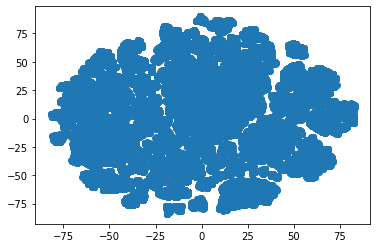

In [21]:
standard_scaler = StandardScaler()
X_df = standard_scaler.fit_transform(df_off)
X_df_new = TSNE(random_state=1337).fit_transform(X_df)
plt.scatter(X_df_new[:,0], X_df_new[:,1]);

In [22]:
def intra_to_inter(X, y, dist, r):
    """Compute intracluster to intercluster distance ratio
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    r : integer
        Number of pairs to sample
        
    Returns
    -------
    ratio : float
        Intracluster to intercluster distance ratio
    """
    intra = []
    inter = []
    np.random.seed(11)
    
    for a, b in np.random.randint(low=0, high=len(y), size=[r,2]):
        if a == b:
            continue   
        
        if y[a] == y[b]:
            intra.append(dist(X[a], X[b]))
        else:
            inter.append(dist(X[a], X[b]))
            
    intra_ave = np.mean(intra)
    inter_ave = np.mean(inter)
    
    return intra_ave / inter_ave

def cluster_range(X, clusterer, k_start, k_stop, actual=None):
    d = {'chs':[], 'iidrs':[], 'inertias':[], 'scs':[], 'ys':[]}
    
    if actual is not None:
        d['ps'] = []
        d['amis'] = []
        d['ars'] = []
        
    for i in range(k_start, k_stop+1):
        cluster = clusterer.set_params(n_clusters=i)
        y_pred = cluster.fit_predict(X)
        
        d['chs'].append(calinski_harabasz_score(X, y_pred))
        d['iidrs'].append(intra_to_inter(X, y_pred, euclidean, 50))
        d['inertias'].append(cluster.inertia_)
        d['scs'].append(silhouette_score(X, y_pred))
        d['ys'].append(cluster.labels_)
        
        if actual is not None:
            d['ps'].append(purity(y_pred, actual))
            d['amis'].append(
                adjusted_mutual_info_score(
                    y_pred, actual, average_method='arithmetic'))
            d['ars'].append(adjusted_rand_score(y_pred, actual))           
            
    return d

def plot_internal(inertias, chs, iidrs, scs):
    """Plot internal validation values"""
    fig, [ax1, ax2, ax3, ax4] = plt.subplots(1,4,figsize=(20,5))
    ks = np.arange(2, len(inertias)+2)
    
    ax1.plot(ks, inertias, '-o', label='SSE')
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('SSE')
    
    ax2.plot(ks, chs, '-ro', label='CH')
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('CH')
    
    ax3.plot(ks, iidrs, '-go', label='Inter-intra')
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('Inter-Intra')
    
    ax4.plot(ks, scs, '-ko', label='Silhouette coefficient')
    ax4.set_xlabel('$k$')
    ax4.set_ylabel('Silhouette')

In [23]:
res_df_off = cluster_range(X_df, KMeans(random_state=1209), 2, 11)

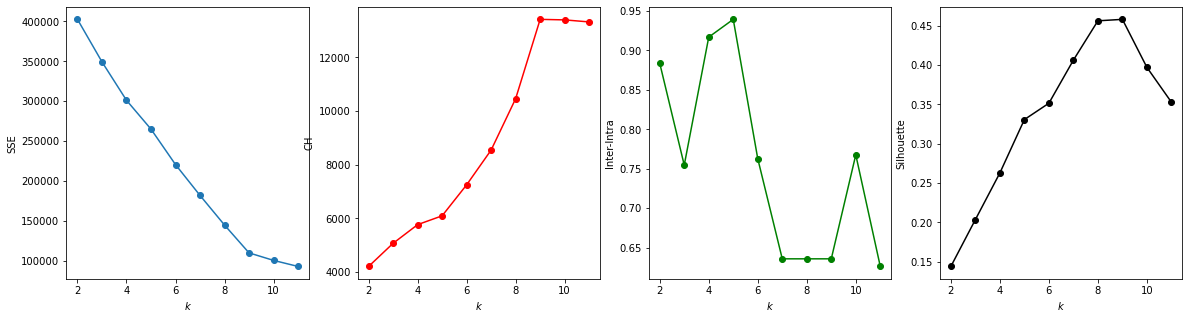

In [24]:
plot_internal(res_df_off['inertias'], res_df_off['chs'],
              res_df_off['iidrs'], res_df_off['scs'])

After performing Kmeans clustering for different values of k, the best value for k was identified. In this case, the best value of k was 2. 

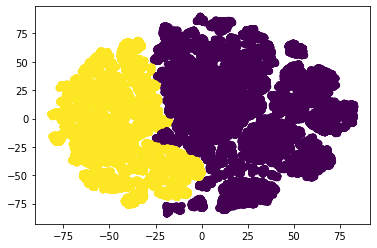

In [25]:
from sklearn.cluster import KMeans
kmeans_country = KMeans(n_clusters=2, random_state=725)
y_predict_ticket = kmeans_country.fit_predict(X_df)
plt.scatter(X_df_new[:,0], X_df_new[:,1], c=y_predict_ticket);

In [26]:
df_off['Cluster'] = y_predict_ticket

In [27]:
df_off['Vehicle Body Type'] = df['Vehicle Body Type']
df_off["Violation County"] = df["Violation County"]
df_off['Violation Code'] = df['Violation Code']
df_off['Violation Time'] = df['Violation Time']
df_off['Street Code1'] = df['Street Code1']
df_off['Street Code2'] = df['Street Code2']
df_off['Street Code3'] = df['Street Code3']

In [28]:
cluster = df_off.groupby('Cluster')

### CLUSTER 0

In [29]:
cluster0 = cluster.get_group(0)
y1 = pd.DataFrame(cluster0)
y1 = y1[['Violation Precinct', 'Hour', 'Month',
         'Vehicle Year', 'Violation Code','Vehicle Body Type', "Street Code1","Street Code2","Street Code3", 
         "Violation County","Cluster"]]

In [30]:
y1.head()

,Violation Precinct,Hour,Month,Vehicle Year,Violation Code,Vehicle Body Type,Street Code1,Street Code2,Street Code3,Violation County,Cluster
512,0,20,1,2011,7,WAGO,0,0,0,MN,0
546,0,19,1,2016,7,SUBN,0,15510,0,BK,0
702,0,15,1,2017,7,SUBN,0,0,0,MN,0
747,0,14,1,2007,7,SUBN,0,0,0,BK,0
981,0,21,1,2007,7,4 DR,0,0,0,ST,0


In [31]:
y1.groupby(['Hour']).agg("count").sort_values(["Vehicle Year"]).tail()

,Violation Precinct,Month,Vehicle Year,Violation Code,Vehicle Body Type,Street Code1,Street Code2,Street Code3,Violation County,Cluster
Hour,,,,,,,,,,
9,1438,1438,1438,1438,1438,1438,1438,1438,1438,1438
14,1666,1666,1666,1666,1666,1666,1666,1666,1666,1666
17,1749,1749,1749,1749,1749,1749,1749,1749,1749,1749
15,1911,1911,1911,1911,1911,1911,1911,1911,1911,1911
16,2063,2063,2063,2063,2063,2063,2063,2063,2063,2063


In [32]:
y1.groupby(['Vehicle Body Type']).agg("count").sort_values(["Vehicle Year"]).tail()

,Violation Precinct,Hour,Month,Vehicle Year,Violation Code,Street Code1,Street Code2,Street Code3,Violation County,Cluster
Vehicle Body Type,,,,,,,,,,
WAGO,716,716,716,716,716,716,716,716,716,716
VAN,2179,2179,2179,2179,2179,2179,2179,2179,2179,2179
4DSD,2751,2751,2751,2751,2751,2751,2751,2751,2751,2751
PICK,3305,3305,3305,3305,3305,3305,3305,3305,3305,3305
SUBN,9085,9085,9085,9085,9085,9085,9085,9085,9085,9085


In [33]:
y1.groupby(['Month']).agg("count").sort_values(["Vehicle Year"]).tail()

,Violation Precinct,Hour,Vehicle Year,Violation Code,Vehicle Body Type,Street Code1,Street Code2,Street Code3,Violation County,Cluster
Month,,,,,,,,,,
10,2041,2041,2041,2041,2041,2041,2041,2041,2041,2041
9,2085,2085,2085,2085,2085,2085,2085,2085,2085,2085
5,2128,2128,2128,2128,2128,2128,2128,2128,2128,2128
8,2271,2271,2271,2271,2271,2271,2271,2271,2271,2271
7,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273


In [35]:
y1.groupby(['Violation Code']).agg("count").sort_values(["Vehicle Year"]).tail()

,Violation Precinct,Hour,Month,Vehicle Year,Vehicle Body Type,Street Code1,Street Code2,Street Code3,Violation County,Cluster
Violation Code,,,,,,,,,,
9,3455,3455,3455,3455,3455,3455,3455,3455,3455,3455
7,19193,19193,19193,19193,19193,19193,19193,19193,19193,19193


### CLUSTER 1

In [36]:
cluster1 = cluster.get_group(1)
y2 = pd.DataFrame(cluster1)
y2 = y2[['Violation Precinct', 'Hour', 'Month',
         'Vehicle Year', 'Violation Code','Vehicle Body Type', "Street Code1","Street Code2","Street Code3", 
         "Violation County","Cluster"]]

In [45]:
y2.head()

,Violation Precinct,Hour,Month,Vehicle Year,Violation Code,Vehicle Body Type,Street Code1,Street Code2,Street Code3,Violation County,Cluster
537,0,19,1,2013,7,UT,0,0,0,QN,1
554,0,19,1,2011,7,SUBN,0,0,0,QN,1
592,0,17,1,2013,7,4DSD,0,0,0,QN,1
1069,0,7,1,2017,7,STAW,0,0,0,QN,1
1398,0,9,1,2011,7,PICK,0,0,0,QN,1


In [38]:
y2.groupby(['Violation County']).agg("count").sort_values(["Vehicle Year"])

,Violation Precinct,Hour,Month,Vehicle Year,Violation Code,Vehicle Body Type,Street Code1,Street Code2,Street Code3,Cluster
Violation County,,,,,,,,,,
QN,12049,12049,12049,12049,12049,12049,12049,12049,12049,12049


In [39]:
y2.groupby(['Hour']).agg("count").sort_values(["Vehicle Year"]).tail()

,Violation Precinct,Month,Vehicle Year,Violation Code,Vehicle Body Type,Street Code1,Street Code2,Street Code3,Violation County,Cluster
Hour,,,,,,,,,,
12,847,847,847,847,847,847,847,847,847,847
13,890,890,890,890,890,890,890,890,890,890
14,951,951,951,951,951,951,951,951,951,951
16,1004,1004,1004,1004,1004,1004,1004,1004,1004,1004
15,1044,1044,1044,1044,1044,1044,1044,1044,1044,1044


In [40]:
y2.groupby(['Month']).agg("count").sort_values(["Vehicle Year"]).tail()

,Violation Precinct,Hour,Vehicle Year,Violation Code,Vehicle Body Type,Street Code1,Street Code2,Street Code3,Violation County,Cluster
Month,,,,,,,,,,
5,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094
10,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101
9,1141,1141,1141,1141,1141,1141,1141,1141,1141,1141
7,1187,1187,1187,1187,1187,1187,1187,1187,1187,1187
8,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263


In [41]:
y2.groupby(['Vehicle Body Type']).agg("count").sort_values(["Vehicle Year"]).tail()

,Violation Precinct,Hour,Month,Vehicle Year,Violation Code,Street Code1,Street Code2,Street Code3,Violation County,Cluster
Vehicle Body Type,,,,,,,,,,
2DSD,310,310,310,310,310,310,310,310,310,310
VAN,948,948,948,948,948,948,948,948,948,948
4DSD,1424,1424,1424,1424,1424,1424,1424,1424,1424,1424
PICK,2348,2348,2348,2348,2348,2348,2348,2348,2348,2348
SUBN,4774,4774,4774,4774,4774,4774,4774,4774,4774,4774


In [42]:
y2.groupby(['Violation Code']).agg("count").sort_values(["Vehicle Year"]).tail()

,Violation Precinct,Hour,Month,Vehicle Year,Vehicle Body Type,Street Code1,Street Code2,Street Code3,Violation County,Cluster
Violation Code,,,,,,,,,,
9,9,9,9,9,9,9,9,9,9,9
7,12040,12040,12040,12040,12040,12040,12040,12040,12040,12040


In [44]:
y2.groupby(['Vehicle Year']).agg("count").sort_values(['Violation Code']).tail()

,Violation Precinct,Hour,Month,Violation Code,Vehicle Body Type,Street Code1,Street Code2,Street Code3,Violation County,Cluster
Vehicle Year,,,,,,,,,,
2014,926,926,926,926,926,926,926,926,926,926
2018,974,974,974,974,974,974,974,974,974,974
2015,1091,1091,1091,1091,1091,1091,1091,1091,1091,1091
2016,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500
2017,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037


## CONCLUSION

After analyzing both clusters, it was also observed that a lot of violations occur during the afternoon around 12-5pm for both clusters. Furthermore, violations are common among Surburban, Pick-up trucks, and 4 door sedans. 

Moreover, it was observed that cluster1 was composed of violations from Queens whereas Cluster0 contains the issued violations for the rest of the counties. Coincidentally, Queens also has the highest vehicle accidents as well as traffic accident injuries (NYPD, 2018).

This does not imply, however, that accidents only occur in Queens nor that other counties are safe from vehicular or traffic accidents. Violations such as passing the red light are serious problems that could lead to dangerous accidents and serious injuries.

In that note, practicing road safety is encouraged among everyone. Participating and cooperating in programs that advocate for road safety are also ideal. 

## REFERENCES

Association for Safe International Road Travel. (n.d.). ROAD SAFETY FACTS. https://www.asirt.org/safe-travel/road-safety-facts/

Hecht, Kleeger, & Damashek. (n.d.). Side-Impact Crashes in NY. https://lawyer1.com/car-accidents/side-impact-collisions/
Insurance Information Institute. (n.d.). Facts + Statistics: Highway safety. https://www.iii.org/fact-statistic/facts-statistics-highway-safety

Insurance Institute for Highway Safety. (2019). Fatality Facts 2019: State by state. https://www.iihs.org/topics/fatality-statistics/detail/state-by-state

Mirman Lawyers. (2018). NYC CAR ACCIDENT STATISTICS. https://mirmanlawyers.com/new-york-car-accident-lawyer/statistics/

National Highway Traffic Safety Administration. (2019). Speeding. https://www.nhtsa.gov/risky-driving/speeding

NYC Department of Finance. (n.d.). Violation Codes, Fines, Rules & Regulations. https://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page

Russell, S. (2019). Funeral for Perth Amboy family members killed in New York DWI crash to be held Friday. https://www.mycentraljersey.com/story/news/crime/2019/06/05/funeral-friday-perth-amboy-nj-family-members-killed-ny-crash/1351164001/

Russell, S. (2019). UPDATE: Perth Amboy girl, 4, remains in critical condition from New York DWI crash. https://www.mycentraljersey.com/story/news/crime/2019/05/31/perth-amboy-girls-remains-critical-following-new-york-car-crash/1298663001/

World Health Organization. (2021). Road traffic injuries. https://www.who.int/news-room/fact-sheets/detail/road-traffic-injuries#:~:text=Approximately%201.3%20million%20people%20die,result%20of%20road%20traffic%20crashes.&text=Road%20traffic%20crashes%20cost%20most,of%20their%20gross%20domestic%20product
